# **STOCK MARKET PREDICTIONS**

# **Data Preprocessing**
The data is scraped from the Alpha_Vantage API and converted to the form necessary for our use.

In [ ]:
# !pip install alpha_vantage

In [54]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import get_dummies
import math
import json
import sys
import csv
import os
import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from tqdm import tqdm_notebook
%matplotlib inline
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import matplotlib
import matplotlib.pyplot as plt
import os
API_KEY = ''

ts = TimeSeries(key= API_KEY, output_format='pandas')
data, meta_data = ts.get_daily_adjusted(symbol='MSFT', outputsize='full')

X = data.drop(['7. dividend amount', '8. split coefficient'],axis=1)[::-1]
X.rename(columns={'1. open':'open', '2. high':'high', '4. close':'close', '6. volume':'volume', '3. low':'low', '5. adjusted close':'adj_close'}, inplace=True)
X

,open,high,low,close,adj_close,volume
date,,,,,,
2000-07-03,79.6900,80.06,79.37,80.00,25.6498,7867400.0
2000-07-05,79.8700,79.87,78.25,78.50,25.1689,17412200.0
2000-07-06,78.8700,81.69,78.50,80.94,25.9512,23936600.0
2000-07-07,81.2700,82.87,80.56,82.00,26.2910,27076600.0
2000-07-10,80.6900,81.31,79.37,79.44,25.4702,26344900.0
...,...,...,...,...,...,...
2020-06-26,199.7300,199.89,194.88,196.33,196.3300,54675780.0
2020-06-29,195.7800,198.53,193.55,198.44,198.4400,26701586.0
2020-06-30,197.8816,204.40,197.74,203.51,203.5100,34310283.0


In [55]:
varInput = X[["open", "high", "low", "close", "adj_close"]]
varInput

,open,high,low,close,adj_close
date,,,,,
2000-07-03,79.6900,80.06,79.37,80.00,25.6498
2000-07-05,79.8700,79.87,78.25,78.50,25.1689
2000-07-06,78.8700,81.69,78.50,80.94,25.9512
2000-07-07,81.2700,82.87,80.56,82.00,26.2910
2000-07-10,80.6900,81.31,79.37,79.44,25.4702
...,...,...,...,...,...
2020-06-26,199.7300,199.89,194.88,196.33,196.3300
2020-06-29,195.7800,198.53,193.55,198.44,198.4400
2020-06-30,197.8816,204.40,197.74,203.51,203.5100


# **Time Series Model**
Applying the Vector Autoregression Model to get the predictions for the next steps.

In [71]:
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random

model = VAR(varInput)
model_fit = model.fit(10)
# make prediction
yhat = model_fit.forecast(model_fit.y, steps=10)
print(yhat.shape)

(10, 5)


No handles with labels found to put in legend.


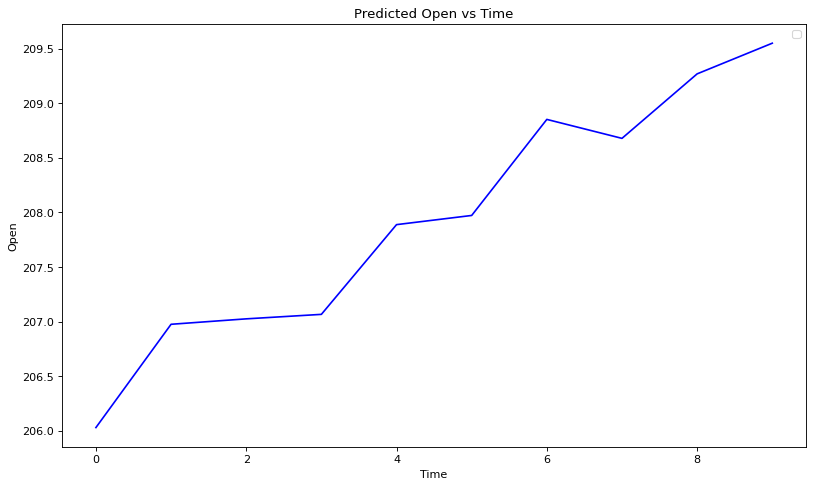

No handles with labels found to put in legend.


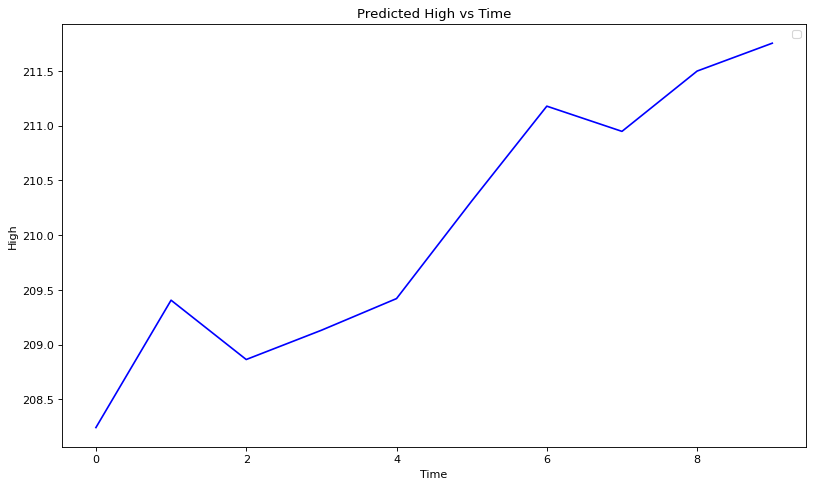

No handles with labels found to put in legend.


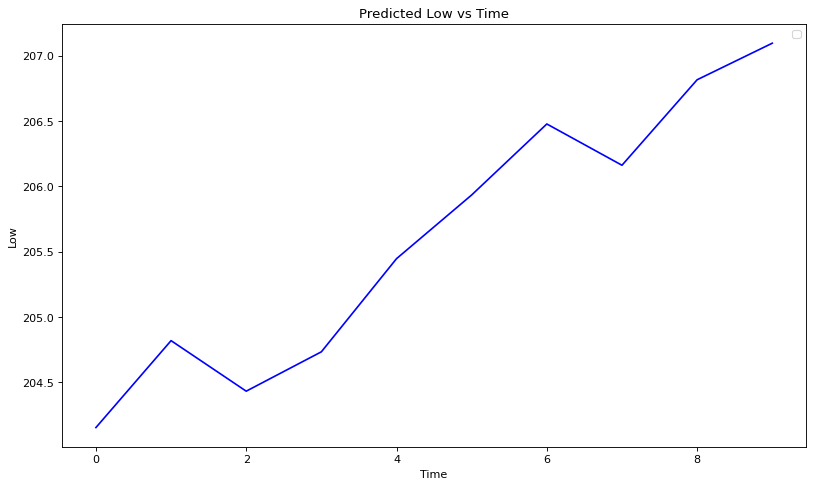

No handles with labels found to put in legend.


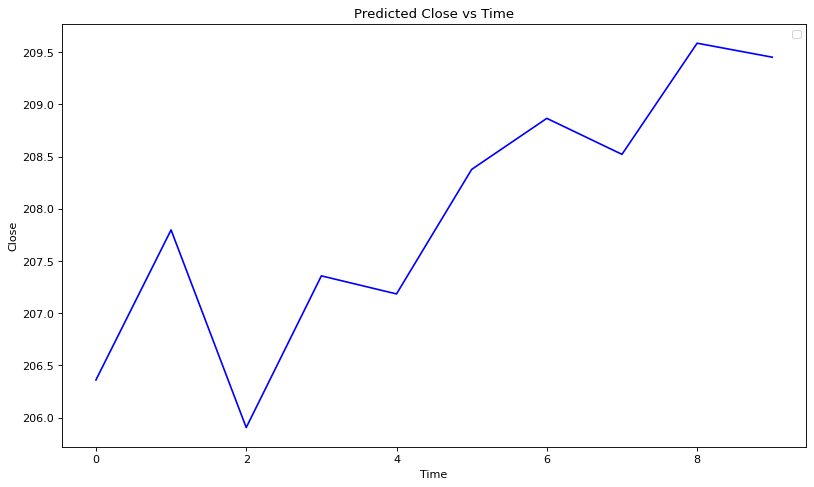

No handles with labels found to put in legend.


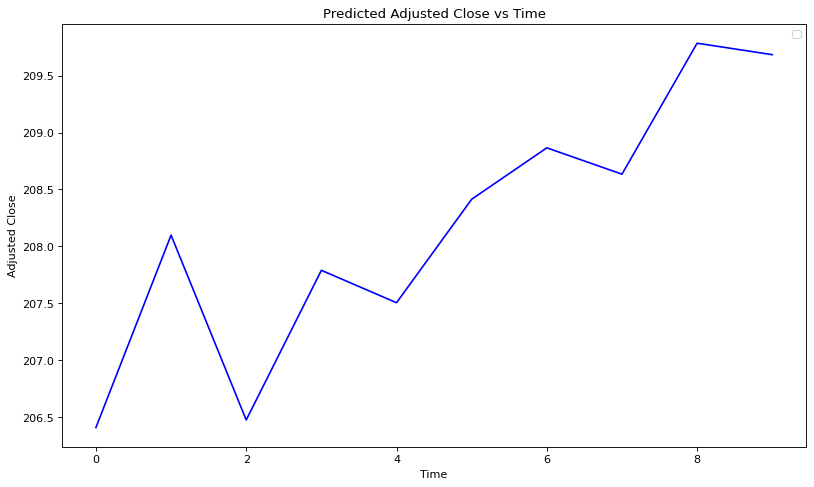

In [72]:
colNames = ['Open', 'High', 'Low', 'Close', 'Adjusted Close']

for i in range(yhat.shape[1]):
  figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(yhat[:,i], color = 'blue')
  plt.title('Predicted '+ colNames[i] + ' vs Time')
  plt.xlabel('Time')
  plt.ylabel(colNames[i])
  plt.legend()
  plt.show()

# **RNN (LSTM) Model**
Applying Deep Learning Model to the dataset helps us to predict the data better that the traditional Time Series Analysis Technique.

In [3]:
stockData = X[['open', 'high', 'low', 'close', 'adj_close']]
stockData = np.array(stockData)
stockData.shape

(5032, 5)

In [4]:
splitIndex = int(stockData.shape[0]*0.85)
stockTrain = stockData[:splitIndex, :]
stockTest = stockData[splitIndex:, :]

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(stockTrain)
testing_scaled = sc.fit_transform(stockTest)

In [8]:
n_len = 15

x_train = []
y_train = []
for i in range(n_len,len(training_scaled)):
    x_train.append(training_scaled[i-n_len:i, :])
    y_train.append(training_scaled[i,:])
x_train,y_train = np.array(x_train),np.array(y_train)
print(x_train.shape)

x_test = []
y_test = []
for i in range(n_len,len(testing_scaled)):
    x_test.append(testing_scaled[i-n_len:i, :])
    y_test.append(testing_scaled[i,:])
x_test,y_test = np.array(x_test),np.array(y_test)

print(x_test.shape)

(4262, 15, 5)
(740, 15, 5)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Bidirectional
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout, BatchNormalization

In [49]:
from tensorflow.keras.backend import clear_session
clear_session()

model_lstm = Sequential()
model_lstm.add(LSTM(units = 75,return_sequences = True,input_shape = (x_train.shape[1],x_train.shape[2])))
model_lstm.add(LSTM(units = 75,return_sequences = True))

model_lstm.add(Dense(units = 100, activation = 'relu'))
model_lstm.add(Dropout(0.15))

model_lstm.add(Dense(units = 96, activation = 'relu'))
model_lstm.add(Dropout(0.1))

model_lstm.add(Dense(units = 32, activation = 'relu'))
model_lstm.add(Dropout(0.05))

model_lstm.add(Dense(units = stockData.shape[1]))

model_lstm.compile(optimizer = 'adam',loss = 'mean_absolute_error')

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 75)            24300     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 75)            45300     
_________________________________________________________________
dense (Dense)                (None, 15, 100)           7600      
_________________________________________________________________
dropout (Dropout)            (None, 15, 100)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 15, 96)            9696      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 96)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 15, 32)            3

In [50]:
model_lstm.fit(x_train,y_train,epochs = 5, batch_size = 1)

Epoch 1/5
4262/4262 [==============================] - 18s 4ms/step - loss: 0.0432
Epoch 2/5
4262/4262 [==============================] - 18s 4ms/step - loss: 0.0324
Epoch 3/5
4262/4262 [==============================] - 18s 4ms/step - loss: 0.0307
Epoch 4/5
4262/4262 [==============================] - 18s 4ms/step - loss: 0.0295
Epoch 5/5
4262/4262 [==============================] - 18s 4ms/step - loss: 0.0281


In [51]:
predictedValues = model_lstm.predict(x_test)
predictedValues = predictedValues[:,-1,:]
predictedValues = sc.inverse_transform(predictedValues)
predictedValues.shape

(740, 5)

In [52]:
# for i in range(predictedValues.shape[0]):
#   print(stockTest[i,0] , '  ' , predictedValues[i,0])

# plt.plot(stockTest[:predictedValues.shape[0],0],color = 'red', label = 'True_Values')
# plt.plot(predictedValues[:,0], color = 'blue', label = 'Predicted_Values')
# plt.title('Open')
# plt.legend()
# plt.show()

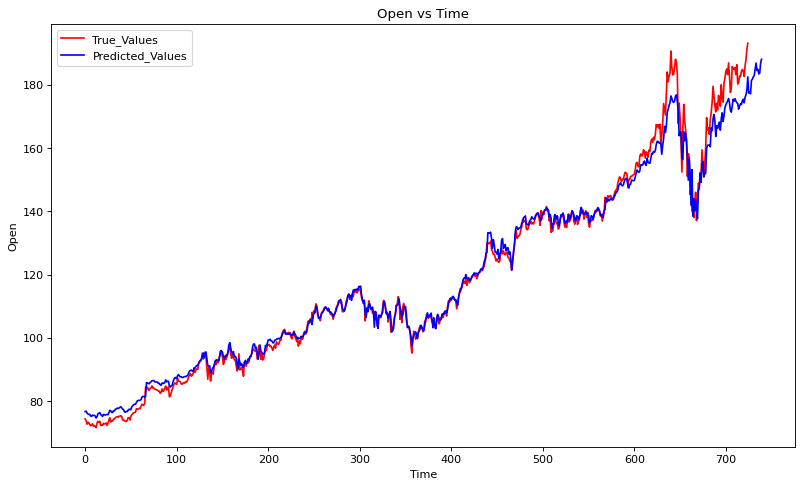

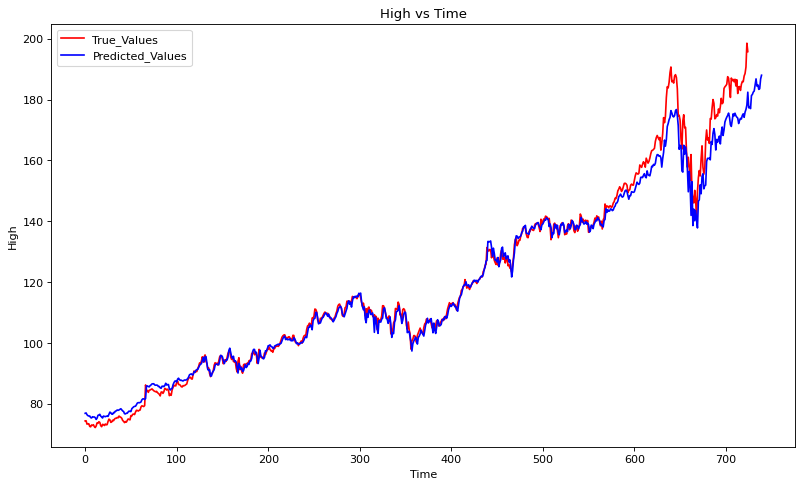

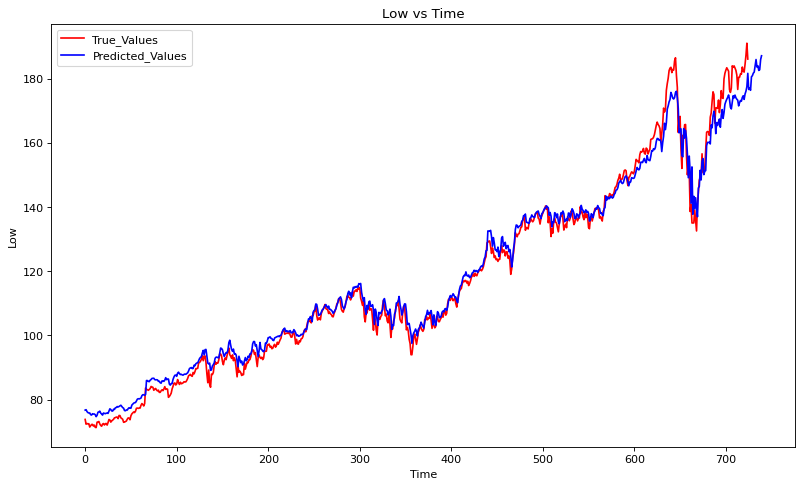

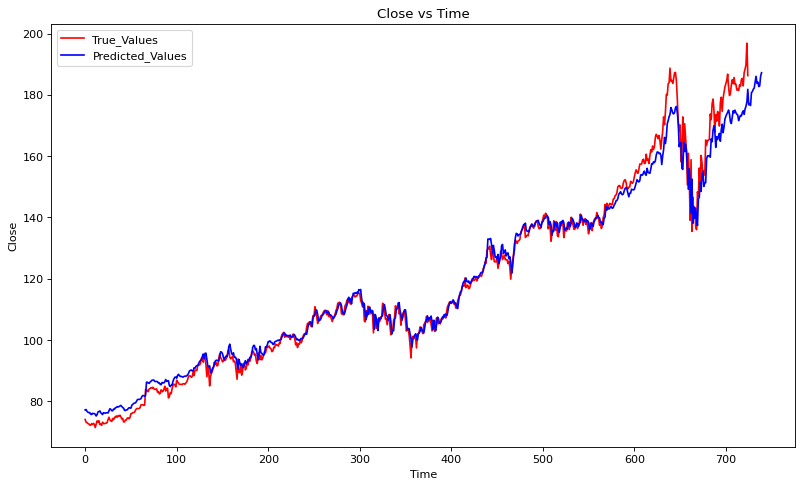

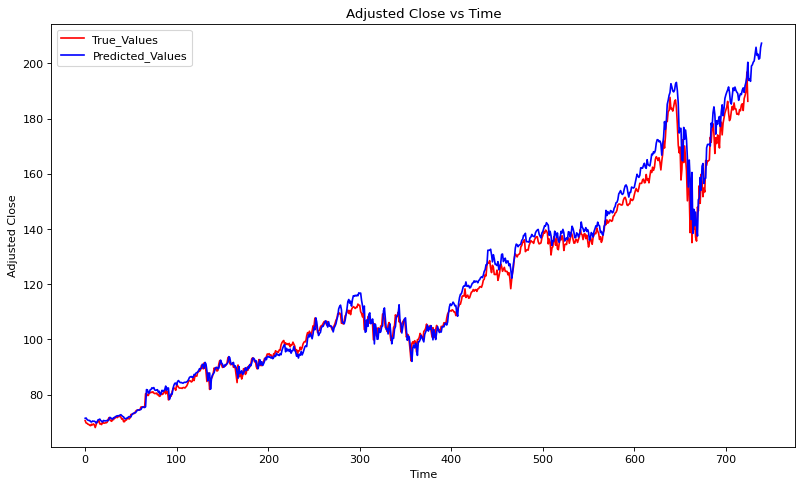

In [53]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


colNames = ['Open', 'High', 'Low', 'Close', 'Adjusted Close']

for i in range(stockTest.shape[1]):
  figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(stockTest[n_len:predictedValues.shape[0],i],color = 'red', label = 'True_Values')
  plt.plot(predictedValues[:,i], color = 'blue', label = 'Predicted_Values')
  plt.title(colNames[i] + ' vs Time')
  plt.xlabel('Time')
  plt.ylabel(colNames[i])
  plt.legend()
  plt.show()